In [23]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
from torch.utils.data import TensorDataset, DataLoader


from astra.torch.models import EfficientNetClassifier
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score

from astra.torch.models import ResNetClassifier
import torchvision.models as models


In [24]:
# Load the saved tensors
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")

# Access the tensors
index = loaded_data['index']
images = loaded_data['images']
labels = loaded_data['labels']
#print shape of tensors
print(images.shape)
print(labels.shape)
#print the labels
print(labels)
#count the number of unique labels
# count the number of 1s and 0s
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

subset_labels = labels[:17000]   
num_ones = np.count_nonzero(subset_labels == 1)
num_zeros = np.count_nonzero(subset_labels == 0)

print(f"Number of 1s(train ): {num_ones}")
print(f"Number of 0s(train): {num_zeros}")

2409


100%|██████████| 300/300 [00:17<00:00, 16.94it/s]


(7500,) torch.Size([7500, 3, 224, 224]) torch.Size([7500])


In [ ]:
train_dataset = TensorDataset(images[:17000], labels[:17000])

test_dataset = TensorDataset(images[17000:], labels[17000:])

print(len(train_dataset))
print(len(test_dataset))
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# print (labels)
#print total positive and negative labels
print (torch.sum(labels), torch.sum(1-labels))


tensor(394) tensor(7106)


In [26]:
dataset= TensorDataset(images, labels)
total_samples = len(dataset)
print(total_samples)
fold_size = total_samples // 4
print(fold_size)
fold_indices = [list(range(i * fold_size, (i + 1) * fold_size)) for i in range(4)]
# print(fold_indices)
fold_loader=[]
for i in range(4):
    test_indices = fold_indices[i]
    train_indices = [idx for j in range(4) if j != i for idx in fold_indices[j]]
    # Create data samplers
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=254, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=254, sampler=test_sampler)
    fold_loader.append((train_loader, test_loader))
print(len(train_indices), len(test_indices))




7500
1875
5625 1875


In [27]:
# train_dataset = TensorDataset(images[:40], labels[:40])
# test_dataset = TensorDataset(images[4:], labels[4:])
# #size of the train dataset
# print(len(train_dataset))
# print(len(test_dataset))

# batch_size = 4
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
# from torchvision.transforms import v2
# mixup = v2.MixUp(alpha=0.5,num_classes=2)

# for images, labels in train_loader:
#     print(f"{images.shape = }, {labels.shape = }")
#     print(labels.dtype)
#     labels=labels.to(torch.int64)
#     mix_images,mix_a,mix_b = mixup_data(images, labels)
#     print(f"{images.shape = }, {labels.shape = }")
#     print(mix_a.dtype)
#     print(mix_a)
#     print(mix_b)
#     # <rest of the training loop here>
#     break

In [30]:
import numpy as np

def mixup_data(x, y, alpha=0.2):
    """
    Mixup data: linearly interpolates between pairs of examples and their labels.

    Args:
    - x: Input data.
    - y: Target labels.
    - alpha: Mixing parameter. Default is 0.4.

    Returns:
    - mixed_x: Mixed input data.
    - mixed_y: Mixed target labels.
    """
    batch_size = x.size(0)
    lam = np.random.beta(alpha, alpha)
    lam = max(lam, 1 - lam)
    print(lam)

    index_a = torch.arange(batch_size).repeat(batch_size)
    index_b = torch.cat([torch.randperm(batch_size) for _ in range(batch_size)])

    mixed_x = lam * x[index_a] + (1 - lam) * x[index_b]
    mixed_y = lam * y[index_a] + (1 - lam) * y[index_b]

    return mixed_x, mixed_y


In [33]:
mixup_probability = 0.5
mixup_alpha = 0.6
for batch_idx, (inputs, targets) in enumerate(train_loader):
    if np.random.rand() < mixup_probability:
        inputs, targets = mixup_data(inputs, targets, alpha=mixup_alpha)

        # Rest of your training loop
        # ...


0.9673985417948678
0.8006753278805674
0.862131986212943
0.786997434281116
0.8961578641873305
0.9521041485599562
0.7848103232975105
0.6280469557446807
0.6794634328980697
0.8129575968505709
0.9166868940456323
0.9787892241415146
0.9970008887767811


In [32]:
print(targets)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


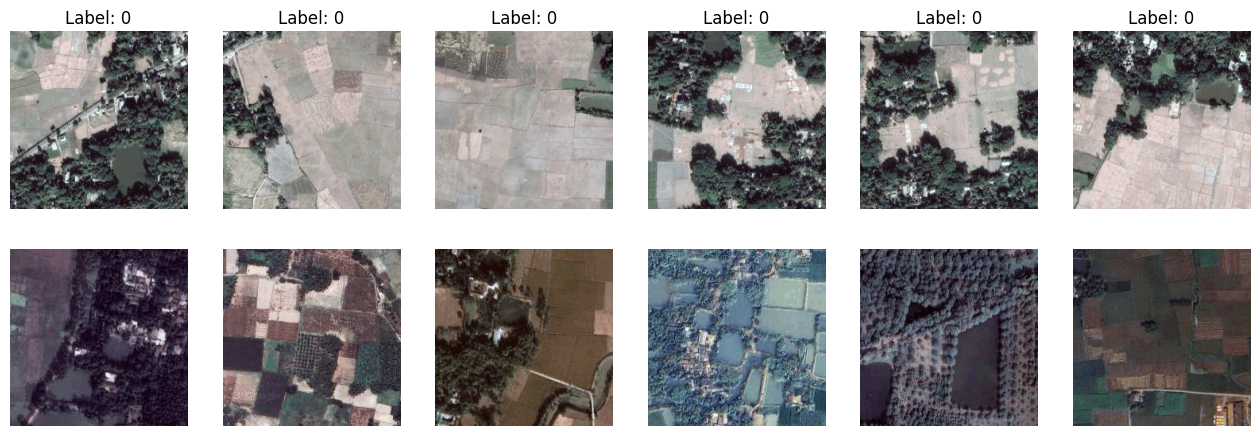

In [21]:
#plot the mixup images 
plt.figure(figsize=(16, 8))
for i in range(6):
    plt.subplot(3, 6, i + 1)
    normalized = (images[i] - images[i].min()) / (images[i].max() - images[i].min())
    plt.imshow(normalized.permute(1, 2, 0))
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

    plt.subplot(3, 6, i + 7)
    mix_normalized = (inputs[i] - inputs[i].min()) / (inputs[i].max() - inputs[i].min())
    plt.imshow(mix_normalized.permute(1, 2, 0))
    # plt.title(f"Label: {mixed_label[i]}")
    plt.axis("off")

NameError: name 'mix_images' is not defined

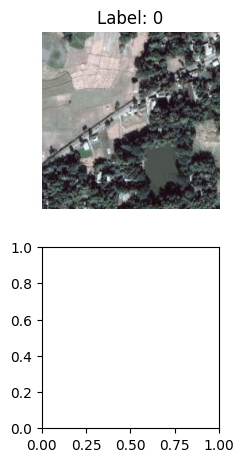

In [22]:
#plot the mixup images 
plt.figure(figsize=(16, 8))
for i in range(6):
    plt.subplot(3, 6, i + 1)
    normalized = (images[i] - images[i].min()) / (images[i].max() - images[i].min())
    plt.imshow(normalized.permute(1, 2, 0))
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

    plt.subplot(3, 6, i + 7)
    mix_normalized = (mix_images[i] - mix_images[i].min()) / (mix_images[i].max() - mix_images[i].min())
    plt.imshow(mix_normalized.permute(1, 2, 0))
    # plt.title(f"Label: {mixed_label[i]}")
    plt.axis("off")

In [ ]:
# import numpy as np

# def mixup_data(x, y, alpha=0.2):
#     """
#     Mixup data: linearly interpolates between pairs of examples and their labels.

#     Args:
#     - x: Input data.
#     - y: Target labels.
#     - alpha: Mixing parameter. Default is 0.4.

#     Returns:
#     - mixed_x: Mixed input data.
#     - target_a: Target labels for the first input.
#     - target_b: Target labels for the second input.
#     """
#     lam = np.random.beta(alpha, alpha)
#     lam = max(lam, 1 - lam)

#     index = torch.arange(0, x.size(0)) % 2 == 0  # Select every third example for mixing

#     mixed_x = lam * x[index] + (1 - lam) * x[index].flip(dims=(0,))
#     target_a, target_b = y[index], y[index].flip(dims=(0,))

#     return mixed_x, target_a, target_b


In [ ]:
mixed_image,target_b=mixup_data(images, labels)
# print(target_a)
print(target_b)

tensor([0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000])


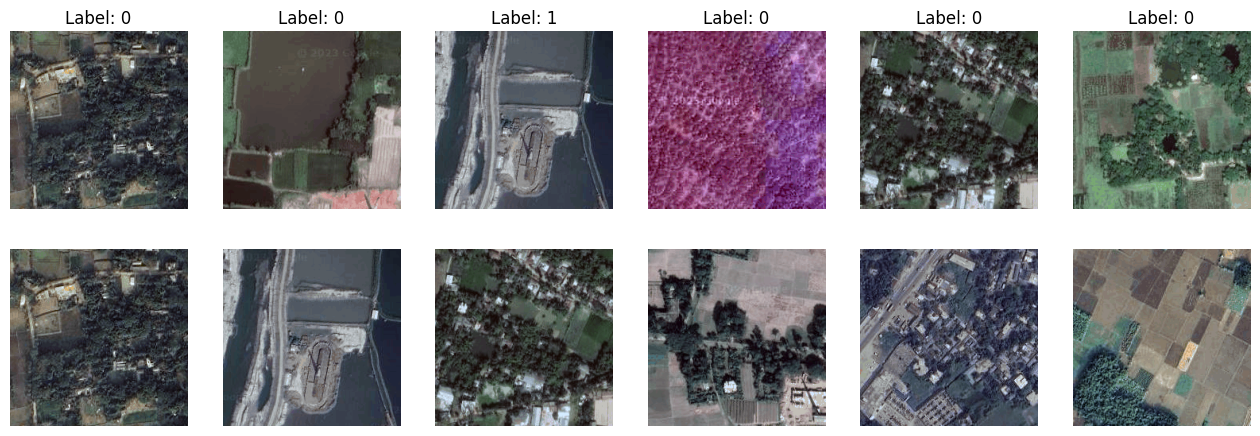

In [ ]:
#plot the mixup images 
plt.figure(figsize=(16, 8))
for i in range(6):
    plt.subplot(3, 6, i + 1)
    normalized = (images[i] - images[i].min()) / (images[i].max() - images[i].min())
    plt.imshow(normalized.permute(1, 2, 0))
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

    plt.subplot(3, 6, i + 7)
    mix_normalized = (mixed_image[i] - mixed_image[i].min()) / (mixed_image[i].max() - mixed_image[i].min())
    plt.imshow(mix_normalized.permute(1, 2, 0))
    # plt.title(f"Label: {mixed_label[i]}")
    plt.axis("off")

images.shape = torch.Size([32, 3, 224, 224]), labels.shape = torch.Size([32])
torch.uint8
images.shape = torch.Size([32, 3, 224, 224]), labels.shape = torch.Size([32])
torch.int64
tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0])


In [ ]:
#total number of images after mixup
print(mix_


16


In [ ]:
import timm
model_name = 'efficientnet_b0'
efficientmodel = timm.create_model(model_name, pretrained=False, num_classes=2)

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

# Apply the random weight initialization to the model
efficientmodel.apply(weights_init)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
efficientmodel.to(device)


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [ ]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

  0%|          | 0/172 [00:00<?, ?it/s]

100%|██████████| 172/172 [01:02<00:00,  2.75it/s]


Train Epoch: 0 	Loss: 0.247679


100%|██████████| 172/172 [01:07<00:00,  2.53it/s]


Train Epoch: 1 	Loss: 0.172859


100%|██████████| 172/172 [01:16<00:00,  2.25it/s]


Train Epoch: 2 	Loss: 0.158438


100%|██████████| 172/172 [01:18<00:00,  2.20it/s]


Train Epoch: 3 	Loss: 0.153332


100%|██████████| 172/172 [01:13<00:00,  2.34it/s]


Train Epoch: 4 	Loss: 0.147552


100%|██████████| 172/172 [01:06<00:00,  2.61it/s]


Train Epoch: 5 	Loss: 0.139434


100%|██████████| 172/172 [01:03<00:00,  2.71it/s]


Train Epoch: 6 	Loss: 0.134699


100%|██████████| 172/172 [01:05<00:00,  2.63it/s]


Train Epoch: 7 	Loss: 0.126421


100%|██████████| 172/172 [00:50<00:00,  3.39it/s]


Train Epoch: 8 	Loss: 0.126286


100%|██████████| 172/172 [00:50<00:00,  3.39it/s]


Train Epoch: 9 	Loss: 0.122455


100%|██████████| 172/172 [01:10<00:00,  2.43it/s]


Train Epoch: 10 	Loss: 0.127875


100%|██████████| 172/172 [01:15<00:00,  2.26it/s]


Train Epoch: 11 	Loss: 0.121339


100%|██████████| 172/172 [00:50<00:00,  3.39it/s]


Train Epoch: 12 	Loss: 0.123664


100%|██████████| 172/172 [00:58<00:00,  2.95it/s]


Train Epoch: 13 	Loss: 0.119241


100%|██████████| 172/172 [00:57<00:00,  3.00it/s]


Train Epoch: 14 	Loss: 0.119393


100%|██████████| 172/172 [00:55<00:00,  3.12it/s]


Train Epoch: 15 	Loss: 0.114802


100%|██████████| 172/172 [01:03<00:00,  2.71it/s]


Train Epoch: 16 	Loss: 0.112940


100%|██████████| 172/172 [00:50<00:00,  3.41it/s]


Train Epoch: 17 	Loss: 0.112623


100%|██████████| 172/172 [00:51<00:00,  3.33it/s]


Train Epoch: 18 	Loss: 0.110208


100%|██████████| 172/172 [00:56<00:00,  3.03it/s]


Train Epoch: 19 	Loss: 0.110430


100%|██████████| 172/172 [01:12<00:00,  2.36it/s]


Train Epoch: 20 	Loss: 0.110970


100%|██████████| 172/172 [00:57<00:00,  3.00it/s]


Train Epoch: 21 	Loss: 0.114608


100%|██████████| 172/172 [00:49<00:00,  3.46it/s]


Train Epoch: 22 	Loss: 0.115557


100%|██████████| 172/172 [00:54<00:00,  3.13it/s]


Train Epoch: 23 	Loss: 0.106865


100%|██████████| 172/172 [01:30<00:00,  1.90it/s]


Train Epoch: 24 	Loss: 0.103612


100%|██████████| 172/172 [01:15<00:00,  2.28it/s]


Train Epoch: 25 	Loss: 0.103690


100%|██████████| 172/172 [01:04<00:00,  2.68it/s]


Train Epoch: 26 	Loss: 0.104926


100%|██████████| 172/172 [01:06<00:00,  2.59it/s]


Train Epoch: 27 	Loss: 0.103654


100%|██████████| 172/172 [01:22<00:00,  2.08it/s]


Train Epoch: 28 	Loss: 0.111819


100%|██████████| 172/172 [00:50<00:00,  3.40it/s]


Train Epoch: 29 	Loss: 0.105691


100%|██████████| 172/172 [00:50<00:00,  3.39it/s]


Train Epoch: 30 	Loss: 0.102976


100%|██████████| 172/172 [00:56<00:00,  3.03it/s]


Train Epoch: 31 	Loss: 0.093239


100%|██████████| 172/172 [00:51<00:00,  3.34it/s]


Train Epoch: 32 	Loss: 0.100021


100%|██████████| 172/172 [01:01<00:00,  2.80it/s]


Train Epoch: 33 	Loss: 0.102497


100%|██████████| 172/172 [00:51<00:00,  3.33it/s]


Train Epoch: 34 	Loss: 0.101164


100%|██████████| 172/172 [00:49<00:00,  3.45it/s]


Train Epoch: 35 	Loss: 0.094154


100%|██████████| 172/172 [00:51<00:00,  3.32it/s]


Train Epoch: 36 	Loss: 0.093658


100%|██████████| 172/172 [00:54<00:00,  3.18it/s]


Train Epoch: 37 	Loss: 0.097738


100%|██████████| 172/172 [00:50<00:00,  3.42it/s]


Train Epoch: 38 	Loss: 0.092822


100%|██████████| 172/172 [00:49<00:00,  3.48it/s]


Train Epoch: 39 	Loss: 0.098411


100%|██████████| 172/172 [00:54<00:00,  3.17it/s]


Train Epoch: 40 	Loss: 0.096088


100%|██████████| 172/172 [00:52<00:00,  3.25it/s]


Train Epoch: 41 	Loss: 0.094683


100%|██████████| 172/172 [00:50<00:00,  3.37it/s]


Train Epoch: 42 	Loss: 0.090563


100%|██████████| 172/172 [00:57<00:00,  3.01it/s]


Train Epoch: 43 	Loss: 0.097462


100%|██████████| 172/172 [01:01<00:00,  2.79it/s]


Train Epoch: 44 	Loss: 0.090073


100%|██████████| 172/172 [01:03<00:00,  2.69it/s]


Train Epoch: 45 	Loss: 0.089679


100%|██████████| 172/172 [01:17<00:00,  2.22it/s]


Train Epoch: 46 	Loss: 0.097449


100%|██████████| 172/172 [00:59<00:00,  2.91it/s]


Train Epoch: 47 	Loss: 0.087328


100%|██████████| 172/172 [00:54<00:00,  3.16it/s]


Train Epoch: 48 	Loss: 0.086800


100%|██████████| 172/172 [01:24<00:00,  2.03it/s]


Train Epoch: 49 	Loss: 0.082656


100%|██████████| 172/172 [01:35<00:00,  1.80it/s]


Train Epoch: 50 	Loss: 0.091505


100%|██████████| 172/172 [01:06<00:00,  2.59it/s]


Train Epoch: 51 	Loss: 0.092558


100%|██████████| 172/172 [01:06<00:00,  2.58it/s]


Train Epoch: 52 	Loss: 0.089080


100%|██████████| 172/172 [01:08<00:00,  2.50it/s]


Train Epoch: 53 	Loss: 0.093429


100%|██████████| 172/172 [00:58<00:00,  2.96it/s]


Train Epoch: 54 	Loss: 0.091481


100%|██████████| 172/172 [01:03<00:00,  2.72it/s]


Train Epoch: 55 	Loss: 0.092105


100%|██████████| 172/172 [01:51<00:00,  1.54it/s]


Train Epoch: 56 	Loss: 0.101558


100%|██████████| 172/172 [01:18<00:00,  2.20it/s]


Train Epoch: 57 	Loss: 0.087810


100%|██████████| 172/172 [00:57<00:00,  3.00it/s]


Train Epoch: 58 	Loss: 0.075680


100%|██████████| 172/172 [01:11<00:00,  2.39it/s]


Train Epoch: 59 	Loss: 0.096355


100%|██████████| 172/172 [01:10<00:00,  2.44it/s]


Train Epoch: 60 	Loss: 0.085404


100%|██████████| 172/172 [03:45<00:00,  1.31s/it]


Train Epoch: 61 	Loss: 0.087532


100%|██████████| 172/172 [01:25<00:00,  2.01it/s]


Train Epoch: 62 	Loss: 0.079330


100%|██████████| 172/172 [01:22<00:00,  2.09it/s]


Train Epoch: 63 	Loss: 0.086821


100%|██████████| 172/172 [01:03<00:00,  2.71it/s]


Train Epoch: 64 	Loss: 0.094908


100%|██████████| 172/172 [00:55<00:00,  3.08it/s]


Train Epoch: 65 	Loss: 0.088159


100%|██████████| 172/172 [00:52<00:00,  3.28it/s]


Train Epoch: 66 	Loss: 0.082940


100%|██████████| 172/172 [00:54<00:00,  3.15it/s]


Train Epoch: 67 	Loss: 0.091246


100%|██████████| 172/172 [00:59<00:00,  2.89it/s]


Train Epoch: 68 	Loss: 0.089481


100%|██████████| 172/172 [01:03<00:00,  2.71it/s]


Train Epoch: 69 	Loss: 0.087354


100%|██████████| 172/172 [01:09<00:00,  2.48it/s]


Train Epoch: 70 	Loss: 0.088279


100%|██████████| 172/172 [00:54<00:00,  3.18it/s]


Train Epoch: 71 	Loss: 0.081423


100%|██████████| 172/172 [00:56<00:00,  3.07it/s]


Train Epoch: 72 	Loss: 0.092135


100%|██████████| 172/172 [01:19<00:00,  2.15it/s]


Train Epoch: 73 	Loss: 0.085339


100%|██████████| 172/172 [01:22<00:00,  2.08it/s]


Train Epoch: 74 	Loss: 0.085566


100%|██████████| 172/172 [01:00<00:00,  2.85it/s]


Train Epoch: 75 	Loss: 0.084109


100%|██████████| 172/172 [00:55<00:00,  3.10it/s]


Train Epoch: 76 	Loss: 0.083965


100%|██████████| 172/172 [01:15<00:00,  2.28it/s]


Train Epoch: 77 	Loss: 0.081344


100%|██████████| 172/172 [01:07<00:00,  2.56it/s]


Train Epoch: 78 	Loss: 0.085194


100%|██████████| 172/172 [01:09<00:00,  2.48it/s]


Train Epoch: 79 	Loss: 0.082405


100%|██████████| 172/172 [00:55<00:00,  3.08it/s]


Train Epoch: 80 	Loss: 0.082945


100%|██████████| 172/172 [01:05<00:00,  2.63it/s]


Train Epoch: 81 	Loss: 0.086449


100%|██████████| 172/172 [01:01<00:00,  2.81it/s]


Train Epoch: 82 	Loss: 0.081641


100%|██████████| 172/172 [00:51<00:00,  3.33it/s]


Train Epoch: 83 	Loss: 0.091509


100%|██████████| 172/172 [00:59<00:00,  2.88it/s]


Train Epoch: 84 	Loss: 0.079244


100%|██████████| 172/172 [01:01<00:00,  2.78it/s]


Train Epoch: 85 	Loss: 0.077621


100%|██████████| 172/172 [00:57<00:00,  3.00it/s]


Train Epoch: 86 	Loss: 0.081973


100%|██████████| 172/172 [00:50<00:00,  3.41it/s]


Train Epoch: 87 	Loss: 0.077639


100%|██████████| 172/172 [01:01<00:00,  2.82it/s]


Train Epoch: 88 	Loss: 0.080615


100%|██████████| 172/172 [02:22<00:00,  1.21it/s]


Train Epoch: 89 	Loss: 0.081472


100%|██████████| 172/172 [02:38<00:00,  1.09it/s]


Train Epoch: 90 	Loss: 0.082344


100%|██████████| 172/172 [00:54<00:00,  3.17it/s]


Train Epoch: 91 	Loss: 0.081996


100%|██████████| 172/172 [00:51<00:00,  3.31it/s]


Train Epoch: 92 	Loss: 0.091841


100%|██████████| 172/172 [00:51<00:00,  3.37it/s]


Train Epoch: 93 	Loss: 0.087441


100%|██████████| 172/172 [00:52<00:00,  3.28it/s]


Train Epoch: 94 	Loss: 0.075692


100%|██████████| 172/172 [00:57<00:00,  3.01it/s]


Train Epoch: 95 	Loss: 0.084216


100%|██████████| 172/172 [01:03<00:00,  2.70it/s]


Train Epoch: 96 	Loss: 0.083054


100%|██████████| 172/172 [01:09<00:00,  2.48it/s]


Train Epoch: 97 	Loss: 0.082838


100%|██████████| 172/172 [01:00<00:00,  2.85it/s]


Train Epoch: 98 	Loss: 0.086499


100%|██████████| 172/172 [00:53<00:00,  3.21it/s]

Train Epoch: 99 	Loss: 0.082542


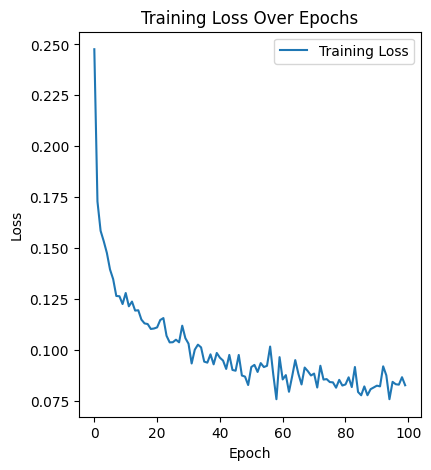

In [ ]:

import torch.optim as optim
from torch.autograd import Variable

from tqdm import tqdm
# Assuming you have defined mixup_data, mixup_criterion, ResNet18, train_loader, device, etc.

# net = EfficientNet(num_classes=2)
# net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientmodel.parameters(), lr=0.001, momentum=0.9)

# Training
loss_list = []
acc_list = []
error_list = []

for epoch in range(50):
    training_loss = 0.0
    correct = 0
    total = 0
    error = 0

    for batch_idx, (input, target) in enumerate(tqdm(train_loader)):
        input, target = input.to(device), target.to(device)
        target=target.to(torch.int64)
        input, targets_a,target_b = mixup(input, target)
        output = efficientmodel(input)
        loss = criterion(output, targets_a)
        training_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        # print(predicted)
        total += target.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(training_loss / len(train_loader))

    print(
        "Train Epoch: {} \tLoss: {:.6f}".format(
            epoch, training_loss / len(train_loader)
        )
    )


# Plotting
plt.figure(figsize=(15, 5))

# Plotting training loss
plt.subplot(1, 3, 1)
plt.plot(loss_list, label="Training Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()








In [ ]:
net.eval()
correct = 0
test_loss = 0
total = 0
from sklearn.metrics import classification_report
y_true = []
y_pred = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        targets=targets.to(torch.int64)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        y_true.append(targets.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
        total += targets.size(0)    
        correct += predicted.eq(targets.data).cpu().sum().float()
print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))        

print('Test Loss: {:.6f}'.format(test_loss / len(test_loader)))
print('Test Accuracy: {:.6f}'.format(correct / total))


100%|██████████| 58/58 [00:15<00:00,  3.64it/s]

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     13956
           1       0.81      0.47      0.60      1100

    accuracy                           0.95     15056
   macro avg       0.89      0.73      0.79     15056
weighted avg       0.95      0.95      0.95     15056

Test Loss: 0.132219
Test Accuracy: 0.953640


In [ ]:
#print the classfication report
from sklearn.metrics import classification_report
y_true = []
y_pred = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(classification_report(y_true, y_pred))

  0%|          | 0/58 [00:00<?, ?it/s]/tmp/ipykernel_3582521/2337674508.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)
100%|██████████| 58/58 [00:09<00:00,  6.20it/s]

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     13956
           1       0.81      0.47      0.60      1100

    accuracy                           0.95     15056
   macro avg       0.89      0.73      0.79     15056
weighted avg       0.95      0.95      0.95     15056

